This document walks through creating a simple college basketball prediction model in Python. This is the modelling portion of the walkthrough, using the cleaned data to make predictions about win margins in games.

# Load Packages and Data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
games = pd.read_csv("games.csv")

## Quick data manipulation

First we need to do one very quick data manipulation step. This is to convert our categorical variable (team location) into a categorical variable in pandas (equivalent to a factor in R). 

In [2]:
games['team_home_away'] = pd.Categorical(
    games['team_home_away'], categories=["away", "home"], ordered=True
)

# Train Test Split

When modelling, it is important to create two sets: a training set and a testing set. The training set is used to fit the model parameters, while the testing set is used for model evaluation. We cannot use the training set for model evaluation because the way training works is that the model calculates its parameters so that it optimizes performance on the training set. The testing set must be used for evaluation because it simulates data the model has not seen before. Usually, the training/testing split is aroudn 80-20 or 70-30. 

In [3]:
# Set seed for reproducibility
np.random.seed(123)

# Split data into training and testing sets (75% train, 25% test)
train_df, test_df = train_test_split(games, test_size=0.25, random_state=123)

# Multiple Linear Regression

## Fitting

A simple model for estimating margin of victory is to use multiple linear regression. As an example, we can use the advanced features that we engineered, along with home court advantage, to calculate the expected margin of victory. 

In `sklearn`, we fit a multiple linear regression using the `sklearn.linear_models.LinearRegression` function, specifying the formula by subsetting the columns of the data frames. 

In [4]:
# Split predictors and dependent variable for train and test sets
X_train = train_df[["eFGP", "TOVP", "ORBP", "FTR", "eFGP.opp", "TOVP.opp", "ORBP.opp", "FTR.opp", "team_home_away"]]
X_train = pd.get_dummies(X_train, drop_first=True)  # Convert categorical variable to dummy variables
y_train = train_df["mov"]

X_test = test_df[["eFGP", "TOVP", "ORBP", "FTR", "eFGP.opp", "TOVP.opp", "ORBP.opp", "FTR.opp", "team_home_away"]]
X_test = pd.get_dummies(X_test, drop_first=True)
y_test = test_df["mov"]

In [5]:
# Fit regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [6]:
# Inspect model coefficients
def coefficients(lm, predictors):
    coef_df = pd.DataFrame({
        'Predictor' : predictors,
        'Coef' : lm.coef_
    })
    return coef_df.sort_values('Coef', ascending = False)

coefficients(lr, X_train.columns)

,Predictor,Coef
3,FTR,15.351053
8,team_home_away_home,5.990943
5,TOVP.opp,1.072633
0,eFGP,0.891124
2,ORBP,0.457178
6,ORBP.opp,-0.515496
4,eFGP.opp,-0.965832
1,TOVP,-1.022498
7,FTR.opp,-15.933065


## Evaluation

To see how well this model performs, we assess its error on the train and test sets. In this example, I use mean squared error. 

One important thing to look out for is how well the model generalizes. A model generalizes well to new data if the error rates between the train and test sets are comparable (the train error will almost always be lower than the test error; we just don't want it to be a lot lower). If the test error is a lot higher than the train error, the model is likely overfitting on the training data, making its predictions on unseen data undependable. 

In [7]:
# function to calculate root mean squared error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# get predictions on train and test set
mlr_train_preds = lr.predict(X_train)
mlr_test_preds = lr.predict(X_test)

# calculate RMSE on train and test set
print("Train RMSE:", rmse(y_train, mlr_train_preds))
print("Test RMSE:", rmse(y_test, mlr_test_preds))

Train RMSE: 11.738275349438876
Test RMSE: 11.815494449678523


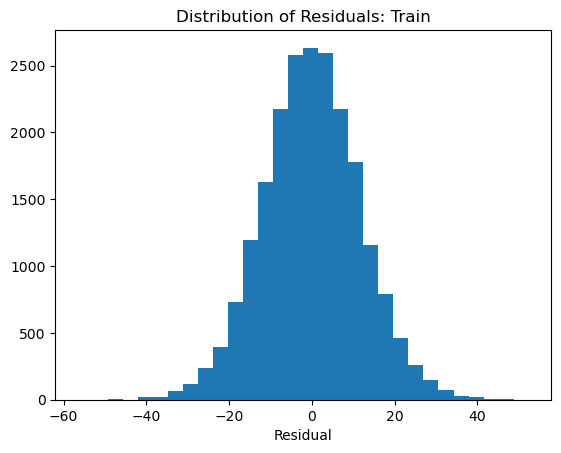

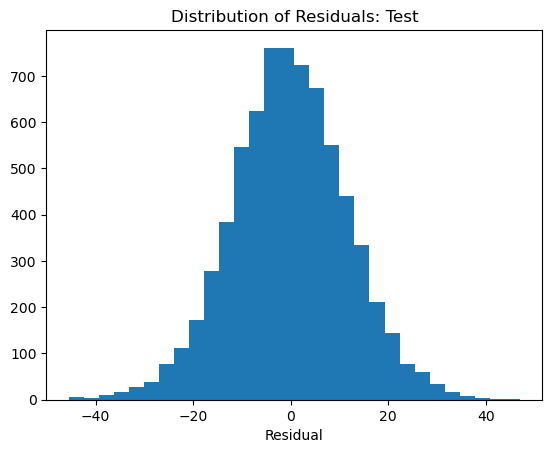

In [8]:
# Inspect distributions of residuals
def resid_plot(y_true, y_pred, label):
    plt.hist(y_true - y_pred, bins = 30)
    plt.xlabel('Residual')
    plt.title(f'Distribution of Residuals: {label}')
    plt.show()

resid_plot(y_train, mlr_train_preds, "Train")
resid_plot(y_test, mlr_test_preds, "Test")

Here, we see that the train and test data have comparable errors, so the model is likely generalizing well. 

# Regularization: Lasso Regression

Another type of model (a perhaps more versatile one) is a LASSO regression. 

LASSO regression uses a regularization term ($\lambda$), which shrinks the coefficients towards zero. This happens because LASSO regression calculates the parameters ($\beta$ values) by minimizing the following equation: 

$$\sum_{i=1}^N \left(y_i - \sum_{j=1}^p x_{ij} \beta_j\right)^2 + \lambda\sum_{j=1}^p |\beta_j|$$

The second term in this equations makes it so that smaller $\beta$ values are favored. The $\lambda$ is a hyperparameter that determines the strength of the regularizaiton. We will optimize this using cross validation (seen later). 

## Data Manipulation

For LASSO regression, there is some more data manipulation. 

For Lasso regression we need to normalize each variable so the $\lambda$ parameter penalizes each parameter equally. This allows the Lasso regularization penalty to be applied to all variables equally. In Python, we can do this using `sklearn.preprocessing.StandardScaler`, which automatically standardizes all columns and stores the means and standard deviations so they can be applied to future datasets. 

In [9]:
# Gather predictors 
unselect = ['game_id', 'season', 'game_date', 'team_id', 'team_location', 'team_score', 'team_id.opp', 'team_location.opp',
            'team_home_away.opp', 'team_score.opp', 'mov', 'team_home_away']

X_train = train_df.drop(columns = unselect)
X_test = test_df.drop(columns = unselect)
pred_cols = X_train.columns

In [10]:
# Normalize using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Naive Linear Regression

First, let's see what happens when we just try to run a multiple linear regression using all of the predictors. 

In [11]:
# Fit multiple linear regression using all variables
lr_big = LinearRegression().fit(X_train, y_train)

# Function to calculate error
def calculate_error(model, X, y):
    return rmse(y, model.predict(X))

# See error on train and test sets
print("Train RMSE:", calculate_error(lr_big, X_train, y_train))
print("Test RMSE:", calculate_error(lr_big, X_test, y_test))

Train RMSE: 11.758242769720656
Test RMSE: 11.892757134642329


In [12]:
coefficients(lr_big, pred_cols)

,Predictor,Coef
50,past_total_rebounds.opp,2.453020e+13
23,past_total_rebounds,2.224345e+13
19,past_technical_fouls,6.440350e+12
46,past_technical_fouls.opp,5.375492e+12
26,past_turnovers,4.995466e+12
53,past_turnovers.opp,3.227960e+11
4,past_team_score,2.816361e+01
36,past_field_goals_made.opp,2.276953e+01
41,past_free_throws_made.opp,1.034082e+01
48,past_three_point_field_goals_made.opp,6.063721e+00


When we look at the errors here, we see don't see a large discrepancy between the train and test errors. There are no immediate signs of overfitting. 

However, when we inspect the coefficients, we see some weird behavior. Many of the coefficient values are huge, thus making them uninterpretable. We can fix this using regularization. 


## Cross Validation and Lasso fitting

To fit the Lasso regression model, we first use cross validation to determine the optimal value for the $\lambda$ hyperparameter. Cross validation works by testing several values for $\lambda$, and for each candidate value, training on $k-1$ partitions (folds) of data while testing on the one partition not used in training. The estimated error for a candidate $\lambda$ is calculated as its average testing performance across all the partitions/folds. 

/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 387.5830472782254, tolerance: 305.0275871414339
  model = cd_fast.enet_coordinate_descent_gram(


Optimal Lambda for LASSO: 0.002974996793958453


/Users/ayushbatra/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.455e+04, tolerance: 3.820e+02
  model = cd_fast.enet_coordinate_descent(


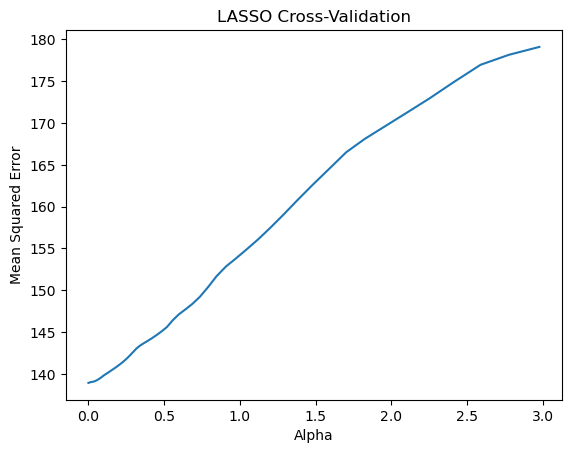

In [13]:
# Fit LASSO with cross-validation
lasso = LassoCV(cv=5, random_state=123).fit(X_train, y_train)

# Best lambda
print("Optimal Lambda for LASSO:", lasso.alpha_)

# Plot cross-validation results
plt.plot(lasso.alphas_, lasso.mse_path_.mean(axis=-1))
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title("LASSO Cross-Validation")
plt.show()

In [14]:
# Inspect coefficients
coefficients(lasso, pred_cols)

,Predictor,Coef
2,ORBP,2.473604e+00
8,past_field_goal_pct,2.418656e+00
22,past_three_point_field_goals_attempted,2.412993e+00
37,past_field_goals_attempted.opp,2.310417e+00
7,past_defensive_rebounds,1.922970e+00
14,past_free_throws_made,1.922053e+00
17,past_steals,1.781291e+00
52,past_total_turnovers.opp,1.706376e+00
43,past_offensive_rebounds.opp,1.512867e+00
28,TOVP.opp,1.400033e+00


In [15]:
# Calculate Errors
print("Train RMSE:", calculate_error(lasso, X_train, y_train))
print("Test RMSE:", calculate_error(lasso, X_test, y_test))

Train RMSE: 11.75918110013387
Test RMSE: 11.89501821886824


After using a Lasso regularization term, we see that the model coefficients make much more sense, and we have even done some automatic feature selection as some of the coefficients were shrunk to zero. 

In general, regularization is a great tool to create more interpretable models and to decrease overfitting. Regularization parameters can almost always be tuned using something like cross validation. 

# Other Models

Other models include tree-based models (decision trees, random forests, xgBoost), Bayesian models, and sports specific models (ELO, player based, possession based, etc.). We cannot cover them all here, but you will almost always need to split data into training and testing sets, use cross validation to optimize hyperparameters, and compare train/test performance to ensure generalization. 